C:\Users\kumar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


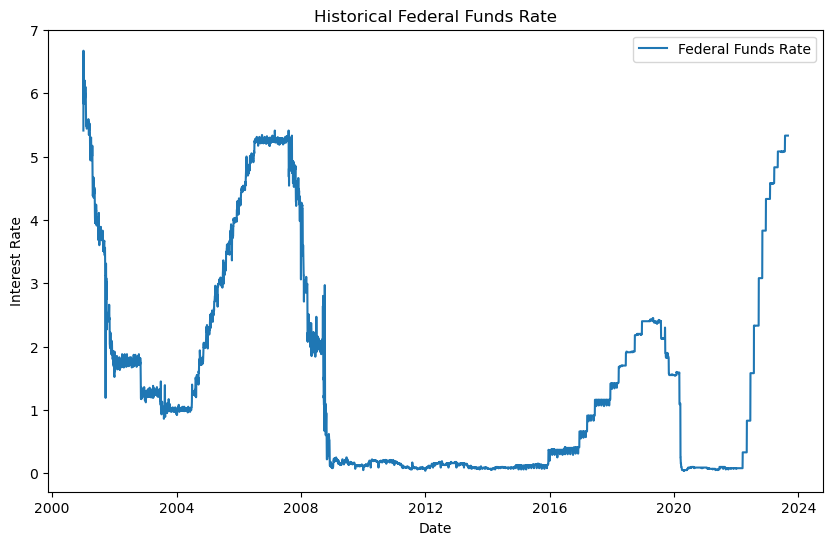

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

start_date = '2001-01-01'
end_date = '2023-08-31'
data = web.DataReader('DFF', 'fred', start_date, end_date)

interest_rates = data.rename(columns={'DFF': 'Rate'})

interest_rates.to_csv("federal_funds_rates.csv")


plt.figure(figsize=(10, 6))
plt.plot(interest_rates, label='Federal Funds Rate')
plt.title('Historical Federal Funds Rate')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()


In [3]:

interest_rates = interest_rates.dropna()
delta_rates = interest_rates.diff().dropna()

def vasicek_log_likelihood(params, rates, delta_rates):
    a, b, sigma = params
    dt = 1 / 252
    r = rates[:-1]
    dr = delta_rates
    mean = a * (b - r) * dt
    variance = sigma ** 2 * dt
    log_likelihood = -np.sum(np.log(variance) + (dr - mean) ** 2 / variance)
    return -log_likelihood

def vasicek_yield_curve(a, b, sigma, r0, maturities):
    yields = []
    for T in maturities:
        B = (1 - np.exp(-a * T)) / a
        A = np.exp((b - sigma**2 / (2 * a**2)) * (B - T) - (sigma**2 * B**2) / (4 * a))
        yield_rate = (-np.log(A) + (B * r0)) / T
        yields.append(yield_rate)
    return np.array(yields)


In [5]:
initial_params = [0.1, interest_rates['Rate'].mean(), interest_rates['Rate'].std()]

bounds = [(0.0001, 1.0), (0.0001, 1.0), (0.0001, 0.5)]


result = minimize(vasicek_log_likelihood, initial_params, args=(interest_rates['Rate'].values, delta_rates['Rate'].values), method='SLSQP', bounds=bounds)


a, b, sigma = result.x

def sse_vasicek(params, observed_yields, maturities, r0):
    a, b, sigma = params
    theoretical_yields = vasicek_yield_curve(a, b, sigma, r0, maturities)
    sse = np.sum((observed_yields - theoretical_yields) ** 2)
    return sse


def recalibrate_vasicek(observed_yields, maturities, r0):
    initial_params = [0.1, 0.1, 0.1]
    bounds = [(0.0001, 1.0), (0.0001, 1.0), (0.0001, 0.5)]
    result = minimize(sse_vasicek, initial_params, args=(observed_yields, maturities, r0), method='SLSQP', bounds=bounds)
    a, b, sigma = result.x
    return a, b, sigma


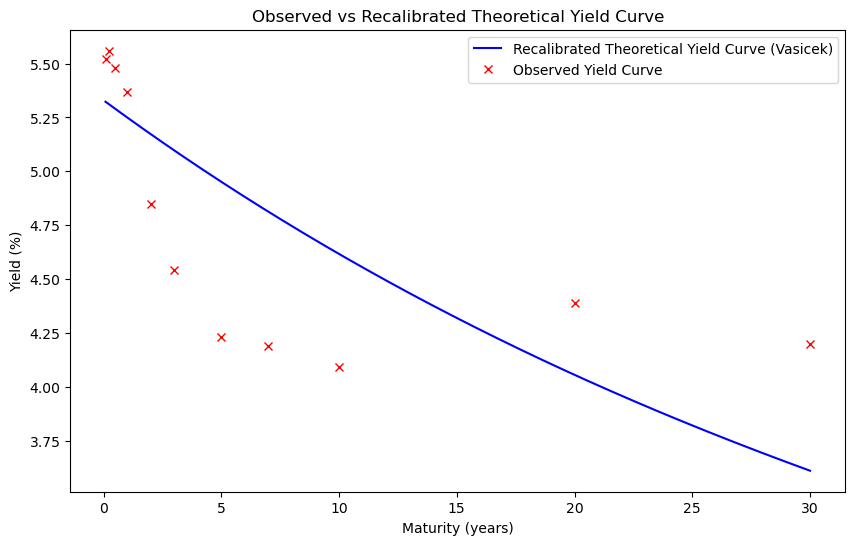

Recalibrated parameters: a=0.03716229681125964, b=1.0, sigma=0.0001


In [7]:
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

yield_data = web.DataReader(['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'], 'fred', '2023-08-31', '2023-08-31')


observed_yields = yield_data.iloc[0].values


r0 = interest_rates['Rate'].iloc[-1]


a_recalibrated, b_recalibrated, sigma_recalibrated = recalibrate_vasicek(observed_yields, maturities, r0)

theoretical_yields_recalibrated = vasicek_yield_curve(a_recalibrated, b_recalibrated, sigma_recalibrated, r0, maturities)


interp_func = interp1d(maturities, theoretical_yields_recalibrated, kind='cubic')
smooth_maturities = np.linspace(maturities.min(), maturities.max(), 500)
smooth_theoretical_yields = interp_func(smooth_maturities)


plt.figure(figsize=(10, 6))
plt.plot(smooth_maturities, smooth_theoretical_yields, label="Recalibrated Theoretical Yield Curve (Vasicek)", linestyle='-', color='blue')
plt.plot(maturities, observed_yields, label="Observed Yield Curve", marker='x', linestyle='None', color='red')
plt.title("Observed vs Recalibrated Theoretical Yield Curve")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.show()


print(f"Recalibrated parameters: a={a_recalibrated}, b={b_recalibrated}, sigma={sigma_recalibrated}")


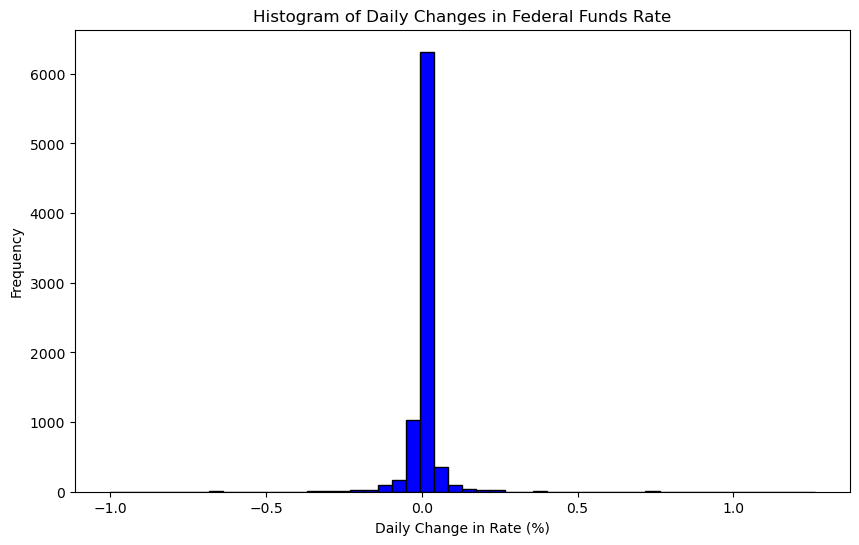

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(delta_rates, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Daily Changes in Federal Funds Rate')
plt.xlabel('Daily Change in Rate (%)')
plt.ylabel('Frequency')
plt.show()


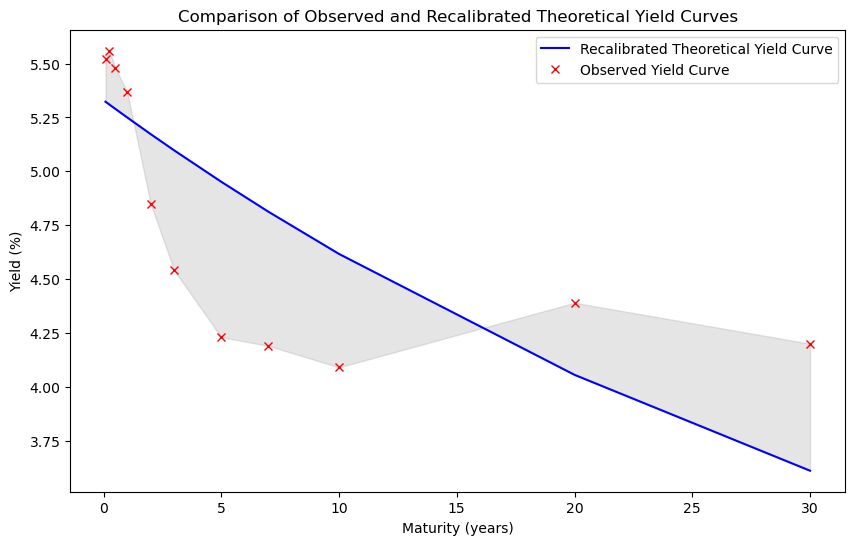

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(maturities, theoretical_yields_recalibrated, label="Recalibrated Theoretical Yield Curve", linestyle='-', color='blue')
plt.plot(maturities, observed_yields, label="Observed Yield Curve", marker='x', linestyle='None', color='red')
plt.fill_between(maturities, theoretical_yields_recalibrated, observed_yields, color='gray', alpha=0.2)
plt.title("Comparison of Observed and Recalibrated Theoretical Yield Curves")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.show()


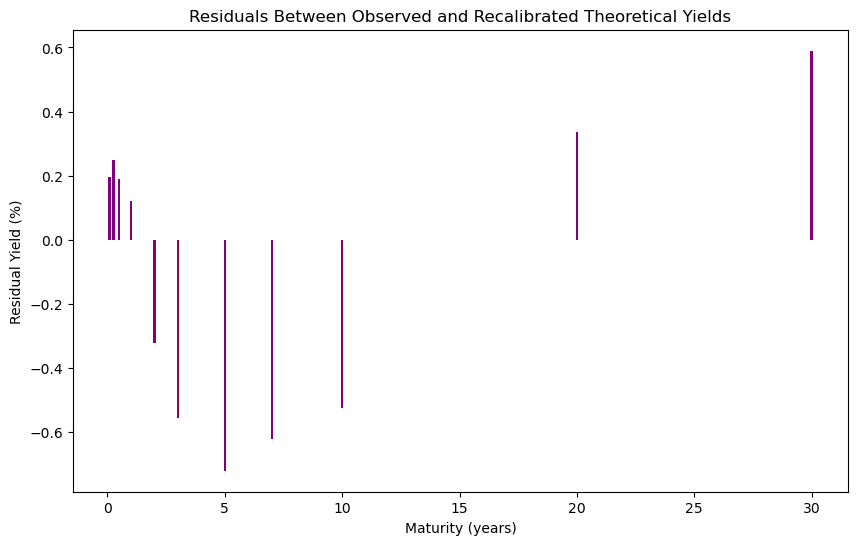

In [11]:
residuals = observed_yields - theoretical_yields_recalibrated

plt.figure(figsize=(10, 6))
plt.bar(maturities, residuals, width=0.1, color='purple')
plt.title('Residuals Between Observed and Recalibrated Theoretical Yields')
plt.xlabel('Maturity (years)')
plt.ylabel('Residual Yield (%)')
plt.show()



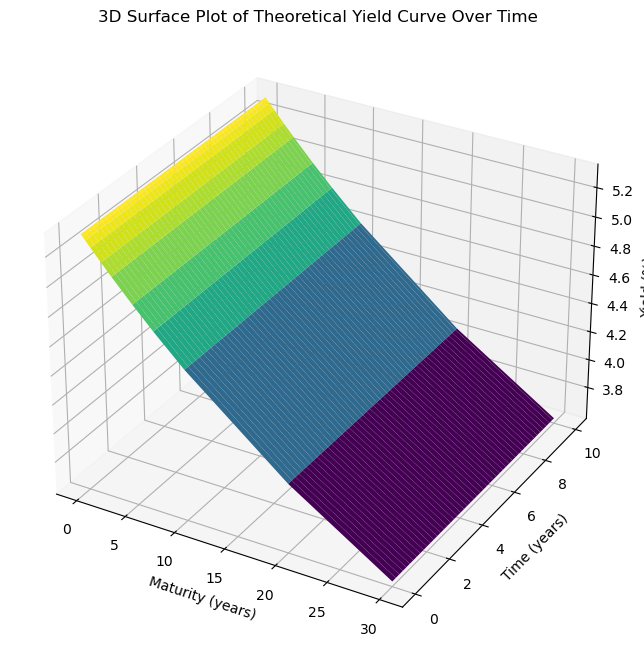

In [12]:
from mpl_toolkits.mplot3d import Axes3D

time_periods = np.linspace(0, 10, 100)  
theoretical_yields_surface = np.array([vasicek_yield_curve(a_recalibrated, b_recalibrated, sigma_recalibrated, r0, maturities) for t in time_periods])

X, Y = np.meshgrid(maturities, time_periods)
Z = theoretical_yields_surface

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_title('3D Surface Plot of Theoretical Yield Curve Over Time')
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Time (years)')
ax.set_zlabel('Yield (%)')
plt.show()


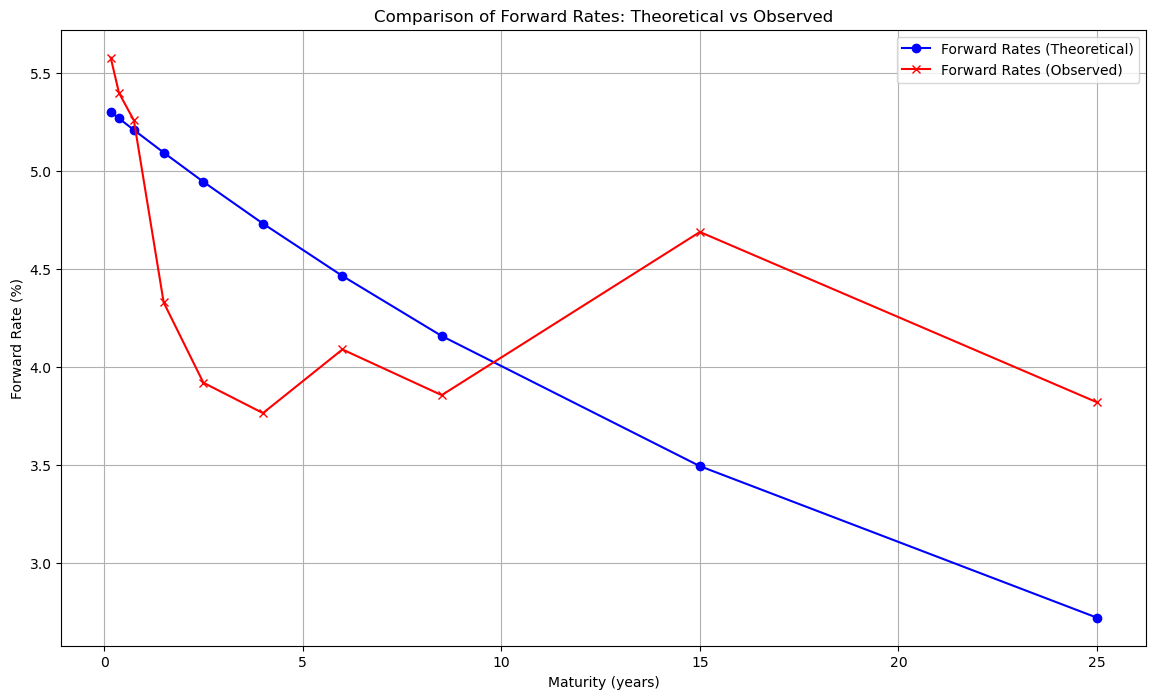

In [18]:

def calculate_forward_rates(yields, maturities):
    forward_rates = []
    for i in range(len(maturities) - 1):
        t1 = maturities[i]
        t2 = maturities[i + 1]
        y1 = yields[i]
        y2 = yields[i + 1]
        forward_rate = ((t2 * y2) - (t1 * y1)) / (t2 - t1)
        forward_rates.append(forward_rate)
    return np.array(forward_rates)


maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])


theoretical_yields_recalibrated = vasicek_yield_curve(a_recalibrated, b_recalibrated, sigma_recalibrated, r0, maturities)


yield_data = web.DataReader(['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'], 'fred', '2023-08-31', '2023-08-31')


observed_yields = yield_data.iloc[0].values


forward_rates_theoretical = calculate_forward_rates(theoretical_yields_recalibrated, maturities)
forward_rates_observed = calculate_forward_rates(observed_yields, maturities)


forward_maturities = maturities[:-1] + np.diff(maturities) / 2


plt.figure(figsize=(14, 8))
plt.plot(forward_maturities, forward_rates_theoretical, label="Forward Rates (Theoretical)", marker='o', linestyle='-', color='blue')
plt.plot(forward_maturities, forward_rates_observed, label="Forward Rates (Observed)", marker='x', linestyle='-', color='red')
plt.title("Comparison of Forward Rates: Theoretical vs Observed")
plt.xlabel("Maturity (years)")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True)
plt.show()
